In [4]:
import sys, os

import tensorflow as tf
import numpy as np
import json
from PIL import Image
import glob

import matplotlib.pyplot as plt

In [5]:
# colab에서 사용한다면 
colab = True

In [6]:
if colab:
  !git clone --depth 1 https://github.com/malheading/Surface_Crack_Segmentation.git

fatal: destination path 'Surface_Crack_Segmentation' already exists and is not an empty directory.


In [7]:
if colab:
    img_positive_path = "/content/Surface_Crack_Segmentation/Positive_jw/"
    img_negative_path = "/content/Surface_Crack_Segmentation/Negative_jw/"
    label_positive_path = "/content/Surface_Crack_Segmentation/Positive_Segmentation/"
    pass
else:
    img_positive_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/Positive_jw/"
    img_negative_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/Negative_jw/"
    label_positive_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/Positive_Segmentation/"
    
positive_imgs = sorted(glob.glob(img_positive_path + "*.*"))
negative_imgs = sorted(glob.glob(img_negative_path + "*.*"))
label_positive_datas = sorted(glob.glob(label_positive_path + "*.*"))

# 이미지 데이터들을 경로에서 불러옵니다.

In [8]:
x_train_positive = []
for i in range(len(positive_imgs)):
    Im = Image.open(positive_imgs[i])
    Im = Im.resize((128,128))
    x_train_positive.append(np.array(Im))
x_train_positive = np.array(x_train_positive,dtype=np.float32)

x_train_negative = []
for i in range(len(negative_imgs)):
    Im = Image.open(negative_imgs[i])
    Im = Im.resize((128,128))
    x_train_negative.append(np.array(Im))
x_train_negative = np.array(x_train_negative, dtype=np.float32)

print("x_train_positive shape :",x_train_positive.shape)
print("x_train_negative shape :",x_train_negative.shape)

x_train_positive shape : (100, 128, 128, 3)
x_train_negative shape : (100, 128, 128, 3)


In [9]:
# 크랙이 있는 것과 없는 것 두가지를 concat해서 x_train 데이터를 만든다.
x_train = np.concatenate((x_train_negative,x_train_positive))
x_train = x_train/255.0
print("x_train shape :",x_train.shape)

x_train shape : (200, 128, 128, 3)


# 균열이 있는 데이터의 라벨(영상 분할)데이터를 경로에서 불러옵니다.

In [10]:
y_train_positive = []
for i in range(len(label_positive_datas)):
    Im = Image.open(label_positive_datas[i])
    Im = Im.resize((128,128),Image.BOX)
    y_train_positive.append(np.ceil(np.array(Im)))
y_train_positive = np.array(y_train_positive,dtype=np.float32)/255.0
y_train_positive = y_train_positive.reshape(y_train_positive.shape[0],y_train_positive.shape[1],y_train_positive.shape[2],1)

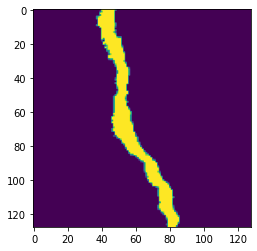

In [11]:
# plt.imshow(y_train_positive[0])
plt.imshow(y_train_positive[0].reshape((128,128)))
# y_train_positive.dtype

# 균열이 없는 데이터의 라벨은 모든 픽셀 값이 0이므로, numpy로 생성합니다.

In [12]:
# negative label은 모든 픽셀의 값이 0
y_train_negative = np.zeros((x_train_negative.shape[0], 128, 128, 1),dtype=np.float32)

# label(y_train)도 concat해준다
y_train = np.concatenate((y_train_negative,y_train_positive))
print(y_train.shape)

(200, 128, 128, 1)


# 데이터셋 형태로 생성

In [13]:
# from_tensor_slice로 데이터셋 생성
BATCH_SIZE=10
dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(BATCH_SIZE)

In [14]:
# 트레인 데이터셋은 0.85 * 200 / 10 --> 170개
# 테스트 데이터셋은 나머지 30개
validation_split = 0.85
train_dataset_size = int(y_train.shape[0] * validation_split / BATCH_SIZE)
train_dataset = dataset.take(train_dataset_size)
test_dataset = dataset.skip(train_dataset_size)

# 모델 정의하기

In [15]:
CHANNEL = 3
OUTPUT_CHANNELS = 3

# 베이스모델로 MobileNetV2를 사용해서, 조금 더 가벼운 네트워크를 구성하고자 합니다.
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, CHANNEL], include_top=False)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

In [16]:
# U-Net에서 특징 추출 레이어로 사용할 계층들입니다.
#이 층들의 활성화를 이용합시다
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

layers = [base_model.get_layer(name).output for name in layer_names]

# U-Net은 다음과 같은 구조로, 일부는 정확한 지역화(Localization)을 수행하게 됩니다.

In [17]:
# U-net은 기본적으로 아래층으로 심층 특징 추출하는 층과, skip하는 층이 합쳐지는 구조# 특징추출 모델을 만듭시다.
# 추가적인 설명은 다음 블로그에서 쉽게 이해할 수 있습니다.
# https://medium.com/@msmapark2/u-net-%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-u-net-convolutional-networks-for-biomedical-image-segmentation-456d6901b28a
# 이를 'down_stack'한다고 합니다.
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# 이미 특징 추출은 MobileNet에서 수행되었기 때문에, trainable = False
down_stack.trainable = False

In [18]:
# up_stack을 1회 수행하는 하나의 계층을 만들도록 upsample 함수를 정의합니다.
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [19]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [20]:
# 모델을 만드는 함수를 정의합니다.
def build_model(num_output_channels):
    input_layer = tf.keras.layers.Input(shape=[128,128,3])
    x = input_layer
    
#     모델을 다운 스택
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
#     skip connection을 upsampling한다
    for up, skip in zip(up_stack,skips):
        x = up(x)
        #  skip해서 넘어오는 connection과 down_stack에서 올라오는 up을 concatenate한다.
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])
        
    # 현재 최종 계층의 output shape = (None, 64,64,1)
    # 마지막 계층으로 Conv2DTranspose를 함으로써, output shape를 (None, 64, 64, Channel)로 지정한다
    last_layer = tf.keras.layers.Conv2DTranspose(num_output_channels, 3, strides=2, padding='same') # 64x64 -> 128,128
    
    x = last_layer(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=x)

# 모델을 컴파일합니다.
### 각각의 픽셀에 대해서 {0,1,2} 3채널의 Sparse Categorical Cross Entropy를 수행하게 됩니다.
### pixcel-wise (픽셀 단위의) 해석이기 때문에 Segmentation의 수행이 가능합니다.

In [21]:
OUTPUT_CHANNELS = 3
model = build_model(OUTPUT_CHANNELS)

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

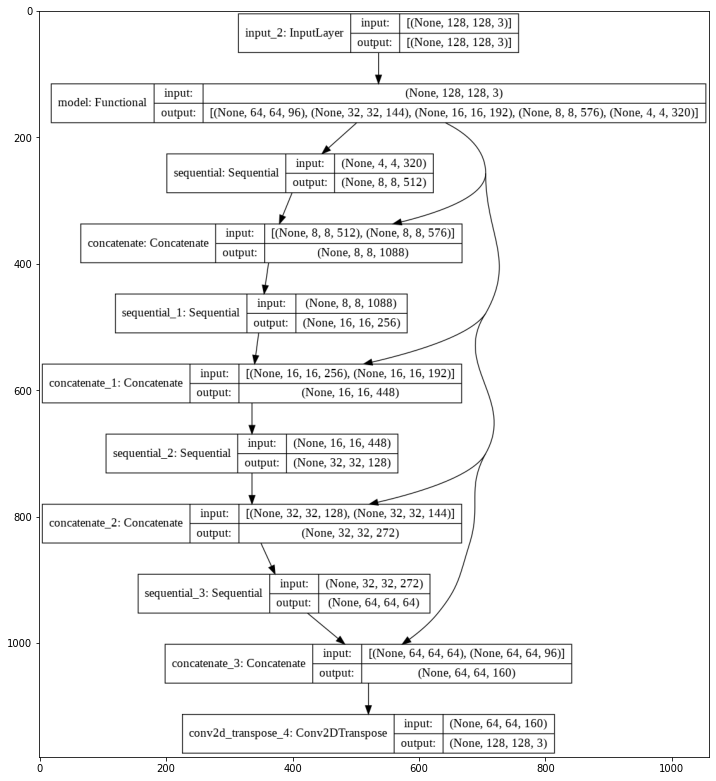

In [22]:
if colab:
    from tensorflow.keras.utils import plot_model
    plot_model(model, show_shapes=True)
    # model.png 파일이 저장된 것을 확인할 수 있습니다.
    plt.figure(figsize=(12,25))
    plt.imshow(np.array(Image.open('model.png')))
else:
     model.summary()   

# 초기 Prediction을 출력해 봅시다(epoch=0).

In [23]:
sample_image, sample_mask = next(iter(dataset))

In [24]:
def show_predictions(dataset=None, num=1,epoch=None):
  if dataset:
    for image, mask in dataset.take(num):
      predicted_mask = model.predict(image)
      # output 3채널 중에서 가장 큰 값들을 찾아서 1채널로 축소
      predicted_mask = tf.argmax(predicted_mask, axis=-1)
      predicted_mask = np.array(predicted_mask).reshape((10,128,128,1))
#       display([image[0], mask[0], predicted_mask])
      
      plt.figure(figsize=(15,5))
      for i in range(BATCH_SIZE):
        plt.subplot(3,BATCH_SIZE,i+1)
        plt.imshow(image[i])
        plt.subplot(3,BATCH_SIZE,i+BATCH_SIZE+1)
        plt.imshow(np.array(mask[i]).reshape(128,128))
        plt.subplot(3,BATCH_SIZE,i+2 * BATCH_SIZE+1)
        plt.imshow(predicted_mask[i].reshape(128,128))
  else:
    predicted_mask = model.predict(sample_image)
    predicted_mask = tf.argmax(predicted_mask, axis=-1)
    predicted_mask = np.array(predicted_mask).reshape((10,128,128,1))
    plt.figure(figsize=(15,5))
    if epoch:
      plt.title("Current epoch :{}".format(epoch))
    for i in range(BATCH_SIZE):
      plt.subplot(3,BATCH_SIZE,i+1)
      plt.imshow(sample_image[i])
      plt.subplot(3,BATCH_SIZE,i+BATCH_SIZE+1)
      plt.imshow(np.array(sample_mask[i]).reshape(128,128))
      plt.subplot(3,BATCH_SIZE,i+2 * BATCH_SIZE+1)
      plt.imshow(predicted_mask[i].reshape(128,128))
#     plt.show()
    if epoch:
        if colab:
          save_path = "/content/Surface_Crack_Segmentation/fig_saves/"
        else:
          save_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/fig_saves/"  #  이미지 저장 경로를 변경해주세요
        file_name = "{}.png".format(epoch)
        plt.savefig(save_path+file_name)
    plt.show()

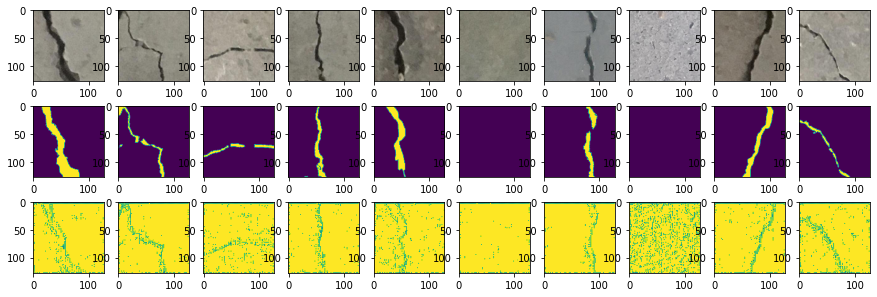

In [25]:
# 트레이닝 되지않은 초기 데이터를 plot
# 다소 약한 Mask들이 나오는 것을 볼 수 있다.
show_predictions(dataset,1)

# 트레이닝

In [26]:
# 각 트레인 epoch가 끝날 때마다 트레이닝 sample_image, sample_mask로부터 학습과정을 시각화합니다.
# tensorflow.keras.callbacks.Callback 클래스로부터 오버로딩합니다.
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(epoch = epoch)

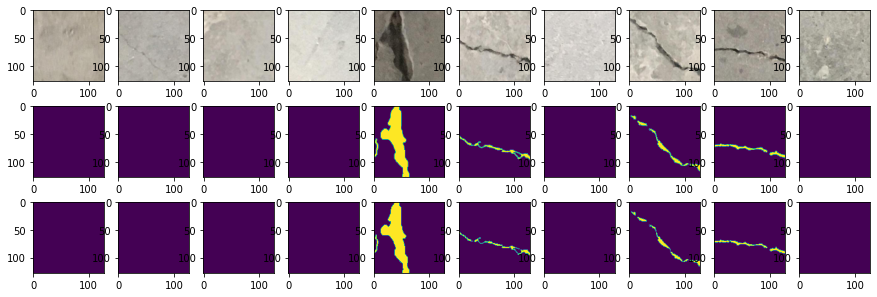

In [27]:
EPOCHS = 100

STEPS_PER_EPOCH = train_dataset_size

# 만일의 사태에 대비해서 체크포인트 콜백을 생성하고 적용하겠습니다.
if colab:
    save_dir = './ckpt_dat/'
    checkpoint_path = save_dir + "{epoch:03d}.ckpt"
    callback_autosave=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=1,save_weights_only=True,save_freq=10)
else:
    checkpoint_path = "D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/CKPT/{epoch:03d}.ckpt"
    callback_autosave=tf.keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=1,save_weights_only=True,save_freq=10)


# 이제 모델을 피팅합니다. 각 epoch이 끝날때마다 학습과정을 시각화합니다.
model_history = model.fit(train_dataset, validation_data=test_dataset, 
                          epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,
                         callbacks=[DisplayCallback(),callback_autosave])

In [28]:
# 모델을 save합니다.
# 사실 이미 체크포인트를 지정했기 때문에, 필요가 없습니다.
if colab:
  model.save("/content/Surface_Crack_Segmentation/MY_MODEL")
else:
    model.save("D:/_김정원/ss_class(AI)/Surface_Crack_Segmentation/MY_MODEL")
    pass

INFO:tensorflow:Assets written to: /content/Surface_Crack_Segmentation/MY_MODEL/assets


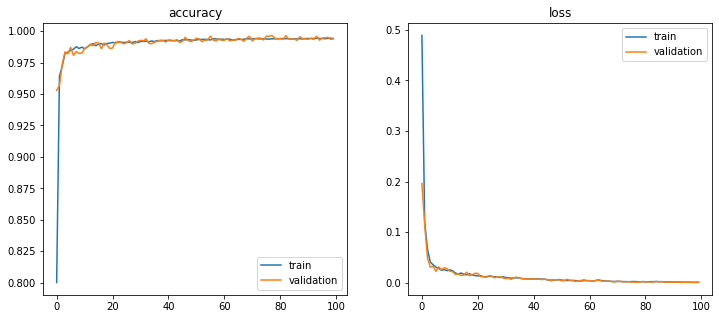

In [29]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(model_history.history['accuracy'],label = 'train')
plt.plot(model_history.history['val_accuracy'], label = 'validation')
plt.title('accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_history.history['loss'],label='train')
plt.plot(model_history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()